Author: Emily Wong \
August 30, 2024

# 1. Import libraries, methods, and data

## 1.1. Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data wrangling
import pandas as pd
import numpy as np
from numpy.random import uniform, normal, seed

# Machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import randint
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
import optuna
import joblib

# Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns # for kernel density plots

# for nested dictionary (calc_weights method)
import collections
def makehash():
    return collections.defaultdict(makehash)

# Fairness
import aif360
import fairlearn
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio, false_negative_rate

## 1.2 Reweighing Method

In [3]:
def calc_weights(df, sens_features_name, outcome_name):
    ''' Calculate sample weights according to calculationg given in 
           F. Kamiran and T. Calders,  "Data Preprocessing Techniques for
           Classification without Discrimination," Knowledge and Information
           Systems, 2012.
    ''' 
    
    # combination of label and groups (outputs a table)
    sens_features = df[sens_features_name]
    outcome = df[outcome_name]
    tab = pd.DataFrame(pd.crosstab(index=sens_features, columns=outcome))

    # reweighing weights
    w = makehash()
    n = len(df)
    for r in tab.index:
        key1 = str(r)
        row_sum = tab.loc[r].sum(axis=0)
        for c in tab.columns:
            key2 = str(c)
            col_sum = tab[c].sum()
            if tab.loc[r,c] == 0:
                n_combo = 1
            else:
                n_combo = tab.loc[r,c]
            val = (row_sum*col_sum)/(n*n_combo)
            w[key1][key2] = val
    
    # Instance weights
    instance_weights = []
    for index, row in df.iterrows():
        race = row[sens_features_name]
        out = row[outcome_name]
        instance_weights.append(w[race][str(out)])

    return instance_weights

In [4]:
def model_eval(model, model_label, X_train, Y_train, X_test, Y_test, outcome_label, W=None, verbose=False):
    results = []
    o = outcome_label
    
    # Fit model
    if W is None:
        model.fit(X_train,Y_train)
    else:
        model.fit(X_train,Y_train, sample_weight=W)
    
    # Model predictions on test
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # Test performance metrics
    test_f1 = np.round(f1_score(Y_test,y_pred),3)
    test_precision = np.round(precision_score(Y_test,y_pred),3)
    test_recall = np.round(recall_score(Y_test,y_pred),3)
    test_balanced_acc = np.round(balanced_accuracy_score(Y_test,y_pred),3)
    test_auc = np.round(roc_auc_score(Y_test,y_pred_prob),3)
    
    # Print model performance
    if verbose == True:
        print('Test AUC:', test_auc)
        print('Test Balanced Accuracy:', test_balanced_acc)
        print('Test F1:', test_f1)
        print('Test Precision:', test_precision)
        print('Test Recall:', test_recall)
        
    # Prepare for fairness evaluation
    y_pred = pd.DataFrame(y_pred,columns=['y_pred'])
    y_pred_prob = pd.DataFrame(y_pred_prob,columns=['y_pred_prob'])
    test_set = pd.concat([y_pred,y_pred_prob,Y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)
    
    # for logistic regression
    if 'MOM_RACE_White' in test_set.columns:
        pass
    else:
        nw_races = ['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
                    'MOM_RACE_Black or African American',
                    'MOM_RACE_Hispanic White',
                    'MOM_RACE_Multiracial',
                    'MOM_RACE_Other',
                    'MOM_RACE_Unknown']
        test_set['MOM_RACE_White'] = test_set[nw_races].apply(lambda row: 1 if (row == 0).all() else 0, axis=1)
    
    if len(test_set[o][test_set['MOM_RACE_White']==1].unique()) < 2:
        auc_white = None
    else:
        auc_white = np.round(roc_auc_score(test_set[o][test_set['MOM_RACE_White']==1],test_set['y_pred_prob'][test_set['MOM_RACE_White']==1]),3)
    
    # Demographic parity
    p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])
    
    # TP and FN
    pos_lab_set_white = test_set[(test_set[o]==1) & (test_set['MOM_RACE_White']==1)]
    pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
    fn_white = np.mean(pos_lab_set_white['fn'])
    pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
    tp_white = np.mean(pos_lab_set_white['tp'])
    
    # FP, TN
    neg_lab_set_white = test_set[(test_set[o]==0) & (test_set['MOM_RACE_White']==1)]
    neg_lab_set_white['fp'] = np.where(neg_lab_set_white['y_pred']==1,1,0)
    fp_white = np.mean(neg_lab_set_white['fp'])
    neg_lab_set_white['tn'] = np.where(neg_lab_set_white['y_pred']==0,1,0)
    tn_white = np.mean(neg_lab_set_white['tn'])
        
    if W is None:
        reweigh_yn = 'No'
    else:
        reweigh_yn = 'Yes'
    
    races = ['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
             'MOM_RACE_Black or African American',
             'MOM_RACE_Hispanic White',
             'MOM_RACE_Multiracial',
             'MOM_RACE_Other',
             'MOM_RACE_Unknown',
             'MOM_RACE_White']
    for r in races:
        pos_lab = test_set[(test_set[o]==1) & (test_set[r]==1)]
        pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
        pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
        
        neg_lab = test_set[(test_set[o]==0) & (test_set[r]==1)]
        neg_lab['fp'] = np.where(neg_lab['y_pred']==1,1,0)
        neg_lab['tn'] = np.where(neg_lab['y_pred']==0,1,0)
        
        if len(test_set[o][test_set[r]==1].unique()) < 2:
            auc = None
        else:
            auc = np.round(roc_auc_score(test_set[o][test_set[r]==1],test_set['y_pred_prob'][test_set[r]==1]),3)
            
        if auc_white == None or auc == None:
            auc_diff = None
        else:
            auc_diff = auc - auc_white
        
        results.append({'Model': model_label,
                        'Reweigh': reweigh_yn,
                        'Iteration': i+1,
                        'Overall Test BA': test_balanced_acc,
                        'Overall Test AUC': test_auc,
                        'Overall Test F1': test_f1,
                        'Overall Test Precision': test_precision,
                        'Overall Test Recall': test_recall,
                        'Race': r,
                        'DP': np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                        'FN':np.mean(pos_lab['fn']),
                        'FN diff':np.mean(pos_lab['fn'])-fn_white,
                        'TP':np.mean(pos_lab['tp']),
                        'TP diff':np.mean(pos_lab['tp'])-tp_white,
                        'FP': np.mean(neg_lab['fp']),
                        'FP diff': np.mean(neg_lab['fp'])-fp_white,
                        'TN': np.mean(neg_lab['tn']),
                        'TN diff': np.mean(neg_lab['tn'])-tn_white,
                        'Test AUC':auc,
                        'Test AUC diff':auc_diff})
    return results

## 1.3. Data

In [6]:
all_data = pd.read_excel("De-identified PMAD data.xlsx")

In [7]:
# Extract relevant variables for model fitting
outcome = 'PHQ9_risk2'
data = all_data[['MOM_AGE','MOM_RACE','ETHNIC_GROUP','MARITAL_STATUS','FINANCIAL_CLASS',
                 'LBW','PTB',
                 'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
                 'PREE','GDM','GHTN',
                 'MOM_BMI','MOM_LOS','CHILD_LOS',
                 'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_PMAD','MENTAL_HEALTH_DX_CUTOFF',
                 'MED_PSYCH','MED_CARDIO',
                 outcome,'PHQ9_VALUE','PMAD_risk']]

## 1.3.3. Curate Data

In [9]:
from statsmodels.stats.proportion import proportions_ztest

df = data.drop([outcome,'PHQ9_VALUE'], axis=1)
df = df.dropna() # keep only complete data
print("N:",df.shape)
print(pd.pivot_table(df, values='MED_PSYCH', index=['MOM_RACE'], aggfunc=['mean']))

nw_races = ['Asian or Native Hawaiian or Other Pacific Islander',
            'Black or African American',
            'Hispanic White',
            'Multiracial',
            'Other',
            'Unknown']

x_white = np.sum(df['MED_PSYCH'][df['MOM_RACE']=='White'])
n_white = len(df['MED_PSYCH'][df['MOM_RACE']=='White'])

for r in nw_races:
    x = np.sum(df['MED_PSYCH'][df['MOM_RACE']==r])
    n = len(df['MED_PSYCH'][df['MOM_RACE']==r])
    
    X = np.array([x_white,x])
    N = np.array([n_white,n])
    
    test_stat, pval = proportions_ztest(count=X, nobs=N, alternative='two-sided')
    print(r,':','Two sided z-test: z = {:.4f}, p value = {:.4f}'.format(test_stat, pval))
    

N: (19430, 24)
                                                        mean
                                                   MED_PSYCH
MOM_RACE                                                    
Asian or Native Hawaiian or Other Pacific Islander  0.093631
Black or African American                           0.109130
Hispanic White                                      0.130836
Multiracial                                         0.156766
Other                                               0.111836
Unknown                                             0.140496
White                                               0.198044
Asian or Native Hawaiian or Other Pacific Islander : Two sided z-test: z = 12.0118, p value = 0.0000
Black or African American : Two sided z-test: z = 8.0234, p value = 0.0000
Hispanic White : Two sided z-test: z = 6.8250, p value = 0.0000
Multiracial : Two sided z-test: z = 2.4923, p value = 0.0127
Other : Two sided z-test: z = 9.4255, p value = 0.0000
Unknown : Two sided

In [10]:
data = data.dropna() # keep only complete data
data = data.drop(['PHQ9_VALUE','PMAD_risk'], axis=1)
print("N:",data.shape)

N: (11377, 24)


10877 500


<BarContainer object of 2 artists>

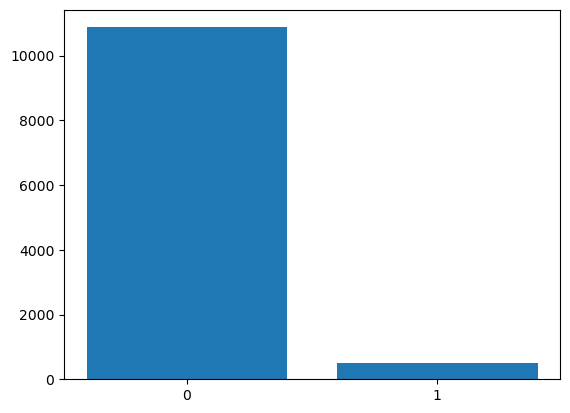

In [11]:
# binary-class
count0, count1 = data[outcome].value_counts()
print(count0, count1)

x = ['0','1']
y = [count0, count1]
plt.bar(x, y)

## 1.3.4. Weight Data

In [13]:
data['w'] = calc_weights(df=data, sens_features_name="MOM_RACE", outcome_name=outcome)

In [14]:
#data[['w',outcome,'MOM_RACE']].drop_duplicates()

## 1.3.5. Get Dummies and Split

In [16]:
# get dummy variables
data = pd.get_dummies(data)

In [17]:
# split into X and y
X = data.drop([outcome], axis=1) 
Y = data[[outcome]]

race = data[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
             'MOM_RACE_Black or African American',
             'MOM_RACE_Multiracial',
             'MOM_RACE_Other',
             'MOM_RACE_Unknown',
             'MOM_RACE_White',
             'MOM_RACE_Hispanic White']]
strat_df = pd.concat([Y,race],axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.90, test_size=0.10, shuffle=True, stratify=strat_df, random_state=2024)
X_test = X_test.drop(['w'], axis=1)

In [18]:
# Split the data into training and validation sets
race = X_train[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
                'MOM_RACE_Black or African American',
                'MOM_RACE_Multiracial',
                'MOM_RACE_Other',
                'MOM_RACE_Unknown',
                'MOM_RACE_White',
                'MOM_RACE_Hispanic White']]
strat_df = pd.concat([y_train,race],axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, test_size=0.15, shuffle=True, stratify=strat_df, random_state=0)
X_val = X_val.drop(['w'], axis=1)

In [19]:
# binary-class
count0_train, count1_train = y_train.value_counts()
print(count0_train, count1_train)

count0_val, count1_val = y_val.value_counts()
print(count0_val, count1_val)

count0_test, count1_test = y_test.value_counts()
print(count0_test, count1_test)

8320 383
1469 67
1088 50


In [20]:
count0, count1 = Y.value_counts()
print(count0,count1)

10877 500


In [21]:
(1088+50)/len(data)

0.10002636899006769

# 2. Handle imbalanced data

## 2.2. Simple Under Sampling Majority (PMAD)

In [24]:
rus = RandomUnderSampler(sampling_strategy = "auto", random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
weights_rus = X_train_rus['w']
X_train_rus = X_train_rus.drop(['w'], axis=1)
y_train_rus.value_counts()

PHQ9_risk2
0.0           383
1.0           383
Name: count, dtype: int64

# 3. Modeling

In [26]:
# Extract weights and drop from training
weights_train = X_train['w']
X_train = X_train.drop(['w'], axis=1)

In [27]:
orig_results = []
n_trials = 100 # for finetuning

## XG Boost Classifier

### Finetune XG Boost Classifier without Reweighing

In [30]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {
        "seed":0,
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 10, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 1e-3, 1),
        "lambda": trial.suggest_int("lambda", 1, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(x, y, verbose=False)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

#optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-08-30 08:54:50,086] A new study created in memory with name: no-name-c9518a67-b4e1-45fb-8edc-1c257637a900
[I 2024-08-30 08:54:51,597] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 549, 'learning_rate': 0.7257005721594281, 'max_depth': 7, 'subsample': 0.5453382998138999, 'lambda': 43, 'min_child_weight': 65}. Best is trial 0 with value: 0.5.
[I 2024-08-30 08:54:52,053] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 438, 'learning_rate': 3.6905577292137615, 'max_depth': 10, 'subsample': 0.3840580773069519, 'lambda': 80, 'min_child_weight': 53}. Best is trial 0 with value: 0.5.
[I 2024-08-30 08:54:52,589] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 569, 'learning_rate': 5.039489598671213, 'max_depth': 1, 'subsample': 0.08804217040183916, 'lambda': 3, 'min_child_weight': 84}. Best is trial 0 with value: 0.5.
[I 2024-08-30 08:54:53,519] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 779, 'learning_rate':

In [31]:
best_xgb = xgb.XGBClassifier(objective='binary:logistic',verbosity=0, seed=0, **study.best_params)
i = -1
orig_XGB = pd.DataFrame(model_eval(model=best_xgb, model_label='XGB', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, verbose=True))

Test AUC: 0.669
Test Balanced Accuracy: 0.638
Test F1: 0.136
Test Precision: 0.077
Test Recall: 0.62


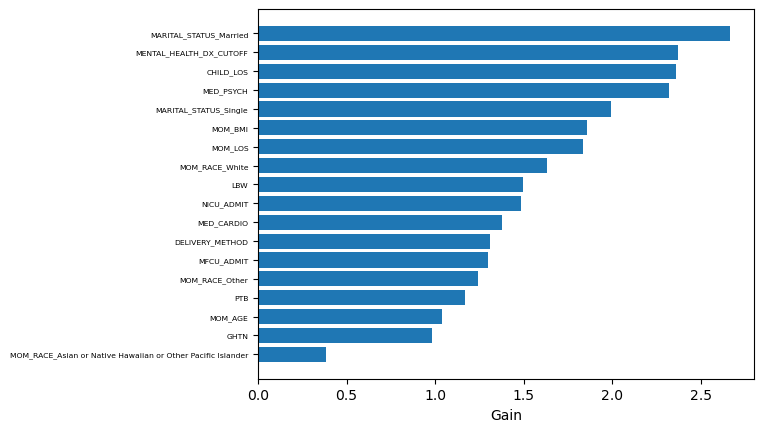

In [32]:
gain = best_xgb.get_booster().get_score(importance_type='gain')
gain_sorted = dict(sorted(gain.items(), key=lambda x: x[1], reverse=False))

features = list(gain_sorted.keys())
values = list(gain_sorted.values())

fig, ax = plt.subplots()
ax.barh(features,values)
plt.yticks(fontsize=5.5)
ax.set_xlabel("Gain")
plt.savefig('PHQ-9 XGB Feature Importance (val).png',dpi=600, bbox_inches='tight')

In [33]:
joblib.dump(best_xgb, 'best_xgb_phq9_no_reweigh_val.pkl')

['best_xgb_phq9_no_reweigh_val.pkl']

### Finetune XG Boost Classifier with Reweighing

In [35]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {
        "seed":0,
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 10, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 1e-3, 1),
        "lambda": trial.suggest_int("lambda", 1, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(x, y, sample_weight=w, verbose=False)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

#optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-08-30 08:56:53,428] A new study created in memory with name: no-name-26a4c1ca-adee-459e-8cb8-d9cc42433a4b
[I 2024-08-30 08:56:57,269] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 549, 'learning_rate': 0.7257005721594281, 'max_depth': 7, 'subsample': 0.5453382998138999, 'lambda': 43, 'min_child_weight': 65}. Best is trial 0 with value: 0.5.
[I 2024-08-30 08:56:57,888] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 438, 'learning_rate': 3.6905577292137615, 'max_depth': 10, 'subsample': 0.3840580773069519, 'lambda': 80, 'min_child_weight': 53}. Best is trial 0 with value: 0.5.
[I 2024-08-30 08:56:59,417] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 569, 'learning_rate': 5.039489598671213, 'max_depth': 1, 'subsample': 0.08804217040183916, 'lambda': 3, 'min_child_weight': 84}. Best is trial 0 with value: 0.5.
[I 2024-08-30 08:57:00,831] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 779, 'learning_rate':

In [36]:
best_xgb2 = xgb.XGBClassifier(objective='binary:logistic',verbosity=0, seed=0, **study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_XGB2 = pd.DataFrame(model_eval(model=best_xgb2, model_label='XGB', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, W=w, verbose=True))

Test AUC: 0.653
Test Balanced Accuracy: 0.642
Test F1: 0.136
Test Precision: 0.076
Test Recall: 0.64


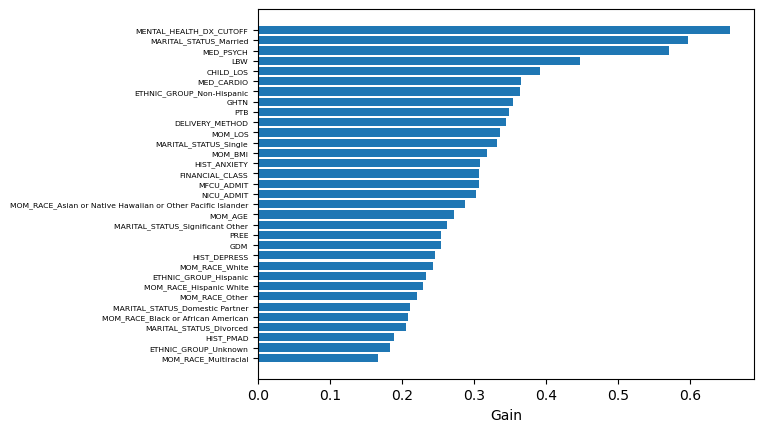

In [37]:
gain = best_xgb2.get_booster().get_score(importance_type='gain')
gain_sorted = dict(sorted(gain.items(), key=lambda x: x[1], reverse=False))

features = list(gain_sorted.keys())
values = list(gain_sorted.values())

fig, ax = plt.subplots()
ax.barh(features,values)
plt.yticks(fontsize=5.5)
ax.set_xlabel("Gain")
plt.savefig('PHQ-9 XGB Feature Importance Reweigh.png',dpi=600, bbox_inches='tight')

In [38]:
joblib.dump(best_xgb2, 'best_xgb_phq9_reweigh_val.pkl')

['best_xgb_phq9_reweigh_val.pkl']

## Random Forest

### Finetune Random Forest without Reweighing

In [41]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {'random_state':0,
             'max_features':'sqrt',
             'ccp_alpha': trial.suggest_float("ccp_alpha", 0, 1),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
             'n_estimators': trial.suggest_int('n_estimators', 1, 1000),
             'max_depth': trial.suggest_int('max_depth', 1, 10)
             }
    model = RandomForestClassifier(**params)
    model.fit(x, y)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-08-30 09:00:04,990] A new study created in memory with name: no-name-4057dbd7-95bc-497a-902d-6fe99dd53bf2
[I 2024-08-30 09:00:05,384] Trial 0 finished with value: 0.5 and parameters: {'ccp_alpha': 0.5488135039273248, 'min_samples_leaf': 36, 'min_samples_split': 31, 'n_estimators': 545, 'max_depth': 5}. Best is trial 0 with value: 0.5.
[I 2024-08-30 09:00:06,096] Trial 1 finished with value: 0.5 and parameters: {'ccp_alpha': 0.6458941130666561, 'min_samples_leaf': 22, 'min_samples_split': 45, 'n_estimators': 964, 'max_depth': 4}. Best is trial 0 with value: 0.5.
[I 2024-08-30 09:00:06,642] Trial 2 finished with value: 0.5 and parameters: {'ccp_alpha': 0.7917250380826646, 'min_samples_leaf': 27, 'min_samples_split': 29, 'n_estimators': 926, 'max_depth': 1}. Best is trial 0 with value: 0.5.
[I 2024-08-30 09:00:07,212] Trial 3 finished with value: 0.5 and parameters: {'ccp_alpha': 0.08712929970154071, 'min_samples_leaf': 2, 'min_samples_split': 42, 'n_estimators': 779, 'max_depth':

In [42]:
best_rf = RandomForestClassifier(random_state=0,max_features='sqrt',**study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_RF = pd.DataFrame(model_eval(model=best_rf, model_label='RF', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, verbose=True))

Test AUC: 0.649
Test Balanced Accuracy: 0.645
Test F1: 0.139
Test Precision: 0.078
Test Recall: 0.64


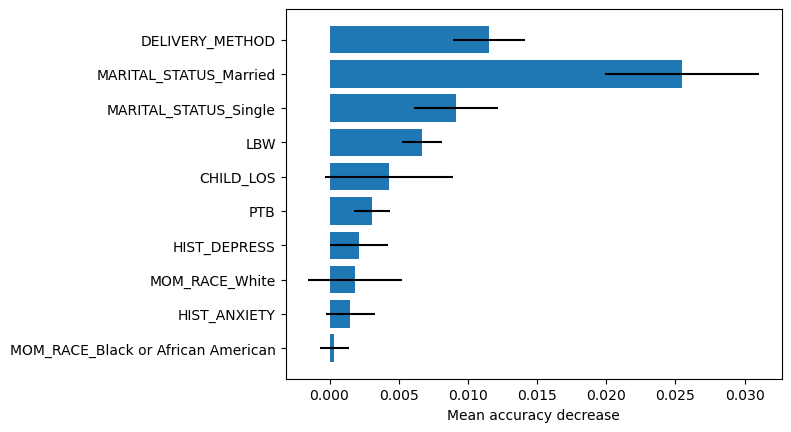

In [43]:
from sklearn.inspection import permutation_importance
imp_result = permutation_importance(
    best_rf, X_test, y_test, n_repeats=10, random_state=2024, n_jobs=2
)

importance_mean = imp_result.importances_mean
importance_sd = imp_result.importances_std

ind = np.argpartition(importance_mean, -10)[-10:]
top_feat = X_test.columns[ind]
top_vals = importance_mean[ind]
top_std = importance_sd[ind]

fig, ax = plt.subplots()
ax.barh(top_feat,top_vals,xerr=top_std)
ax.set_xlabel("Mean accuracy decrease")
plt.savefig('PHQ-9 RF Feature Importance (val).png',dpi=600, bbox_inches='tight')

In [44]:
joblib.dump(best_rf, 'best_rf_phq9_no_reweigh_val.pkl')

['best_rf_phq9_no_reweigh_val.pkl']

### Finetune Random Forest with Reweighing

In [46]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {'random_state':0,
             'max_features':'sqrt',
             'ccp_alpha': trial.suggest_float("ccp_alpha", 0, 1),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
             'n_estimators': trial.suggest_int('n_estimators', 1, 1000),
             'max_depth': trial.suggest_int('max_depth', 1, 10)
             }
    model = RandomForestClassifier(**params)
    model.fit(x, y, sample_weight=w)
    predictions = model.predict(X_val)
    predictions_prob = model.predict_proba(X_val)[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-08-30 09:00:40,763] A new study created in memory with name: no-name-cc8bccf9-5f9d-4089-8911-ae24a4d88b2d
[I 2024-08-30 09:00:41,119] Trial 0 finished with value: 0.5 and parameters: {'ccp_alpha': 0.5488135039273248, 'min_samples_leaf': 36, 'min_samples_split': 31, 'n_estimators': 545, 'max_depth': 5}. Best is trial 0 with value: 0.5.
[I 2024-08-30 09:00:41,731] Trial 1 finished with value: 0.5 and parameters: {'ccp_alpha': 0.6458941130666561, 'min_samples_leaf': 22, 'min_samples_split': 45, 'n_estimators': 964, 'max_depth': 4}. Best is trial 0 with value: 0.5.
[I 2024-08-30 09:00:42,235] Trial 2 finished with value: 0.5 and parameters: {'ccp_alpha': 0.7917250380826646, 'min_samples_leaf': 27, 'min_samples_split': 29, 'n_estimators': 926, 'max_depth': 1}. Best is trial 0 with value: 0.5.
[I 2024-08-30 09:00:42,857] Trial 3 finished with value: 0.5 and parameters: {'ccp_alpha': 0.08712929970154071, 'min_samples_leaf': 2, 'min_samples_split': 42, 'n_estimators': 779, 'max_depth':

In [47]:
best_rf2 = RandomForestClassifier(random_state=0,max_features='sqrt',**study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_RF2 = pd.DataFrame(model_eval(model=best_rf2, model_label='RF', X_train=x, Y_train=y, X_test=X_test, Y_test=y_test, outcome_label=outcome, W=w, verbose=True))

Test AUC: 0.657
Test Balanced Accuracy: 0.629
Test F1: 0.129
Test Precision: 0.072
Test Recall: 0.64


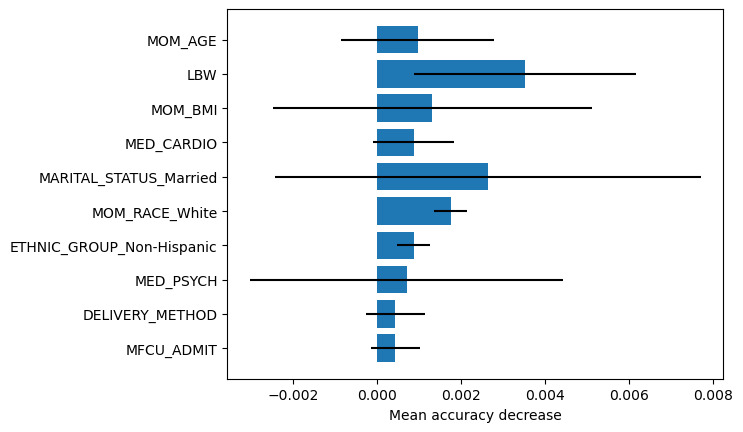

In [48]:
from sklearn.inspection import permutation_importance
imp_result = permutation_importance(
    best_rf2, X_test, y_test, n_repeats=10, random_state=2024, n_jobs=2
)

importance_mean = imp_result.importances_mean
importance_sd = imp_result.importances_std

ind = np.argpartition(importance_mean, -10)[-10:]
top_feat = X_test.columns[ind]
top_vals = importance_mean[ind]
top_std = importance_sd[ind]

fig, ax = plt.subplots()
ax.barh(top_feat,top_vals,xerr=top_std)
ax.set_xlabel("Mean accuracy decrease")
plt.savefig('PHQ-9 RF Feature Importance Reweigh (val).png',dpi=600, bbox_inches='tight')

In [49]:
joblib.dump(best_rf2, 'best_rf_phq9_reweigh_val.pkl') 

['best_rf_phq9_reweigh_val.pkl']

## Logistic Regression

### Finetune Logistic Regression without Reweighing

In [52]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {'penalty':'l2',
             'C':trial.suggest_loguniform("C", 1e-2, 1),
             'tol':trial.suggest_uniform('tol' , 1e-6 , 1e-3)
             }
    model = LogisticRegression(**params)
    model.fit(x.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']),y)
    predictions = model.predict(X_val.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']))
    predictions_prob = model.predict_proba(X_val.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']))[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-08-30 09:01:35,000] A new study created in memory with name: no-name-a41970f1-c589-4358-a338-f9b48aaf2a8a
[I 2024-08-30 09:01:35,260] Trial 0 finished with value: 0.5894861973319245 and parameters: {'C': 0.12520653814999466, 'tol': 0.0007154741770060471}. Best is trial 0 with value: 0.5894861973319245.
[I 2024-08-30 09:01:35,347] Trial 1 finished with value: 0.589973888217185 and parameters: {'C': 0.16051911333587626, 'tol': 0.0005453382998139}. Best is trial 1 with value: 0.589973888217185.
[I 2024-08-30 09:01:35,828] Trial 2 finished with value: 0.587484632657001 and parameters: {'C': 0.07035737028722149, 'tol': 0.0006462482189535895}. Best is trial 1 with value: 0.589973888217185.
[I 2024-08-30 09:01:37,257] Trial 3 finished with value: 0.5892931530231754 and parameters: {'C': 0.07501954443620121, 'tol': 0.0008918812277812978}. Best is trial 1 with value: 0.589973888217185.
[I 2024-08-30 09:01:37,428] Trial 4 finished with value: 0.5937636528047305 and parameters: {'C': 0.84

In [53]:
best_glm = LogisticRegression(penalty='l2',**study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_GLM = pd.DataFrame(model_eval(model=best_glm, model_label='GLM', 
                                   X_train=x.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                   Y_train=y, 
                                   X_test=X_test.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                   Y_test=y_test, outcome_label=outcome, verbose=True))

Test AUC: 0.669
Test Balanced Accuracy: 0.622
Test F1: 0.127
Test Precision: 0.071
Test Recall: 0.62


In [54]:
best_glm = LogisticRegression(penalty='l2',**study.best_params)

In [55]:
joblib.dump(best_glm, 'best_glm_phq9_no_reweigh_val.pkl') 

['best_glm_phq9_no_reweigh_val.pkl']

### Finetune Logistic Regression with Reweighing

In [57]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {'penalty':'l2',
             'C':trial.suggest_loguniform("C", 1e-2, 1),
             'tol':trial.suggest_uniform('tol' , 1e-6 , 1e-3)
             }
    model = LogisticRegression(**params)
    model.fit(x.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), y, sample_weight=w)
    predictions = model.predict(X_val.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']))
    predictions_prob = model.predict_proba(X_val.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']))[:,1]
    BA = balanced_accuracy_score(y_val, predictions)
    AUC = roc_auc_score(y_val, predictions_prob)
    return AUC

sampler = optuna.samplers.TPESampler(seed=0, consider_prior=True, prior_weight=0.5) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=n_trials)

[I 2024-08-30 09:01:59,821] A new study created in memory with name: no-name-eefc04c9-1318-48d9-93b5-106f0ae723c5
[I 2024-08-30 09:02:01,018] Trial 0 finished with value: 0.5776901740446847 and parameters: {'C': 0.12520653814999466, 'tol': 0.0007154741770060471}. Best is trial 0 with value: 0.5776901740446847.
[I 2024-08-30 09:02:01,518] Trial 1 finished with value: 0.5779645001676438 and parameters: {'C': 0.16051911333587626, 'tol': 0.0005453382998139}. Best is trial 1 with value: 0.5779645001676438.
[I 2024-08-30 09:02:01,594] Trial 2 finished with value: 0.5814088170447964 and parameters: {'C': 0.07035737028722149, 'tol': 0.0006462482189535895}. Best is trial 2 with value: 0.5814088170447964.
[I 2024-08-30 09:02:01,761] Trial 3 finished with value: 0.5773447263342918 and parameters: {'C': 0.07501954443620121, 'tol': 0.0008918812277812978}. Best is trial 2 with value: 0.5814088170447964.
[I 2024-08-30 09:02:01,826] Trial 4 finished with value: 0.5763591843369944 and parameters: {'C':

In [58]:
best_glm2 = LogisticRegression(penalty='l2',**study.best_params)

# original evaluation 
i = -1 # (will output as 0 since iteration = i+1)
orig_GLM2 = pd.DataFrame(model_eval(model=best_glm2, model_label='GLM', 
                                    X_train=x.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                    Y_train=y, 
                                    X_test=X_test.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                    Y_test=y_test, outcome_label=outcome, W=w, verbose=True))

Test AUC: 0.672
Test Balanced Accuracy: 0.661
Test F1: 0.15
Test Precision: 0.085
Test Recall: 0.64


In [59]:
joblib.dump(best_glm2, 'best_glm_phq9_reweigh_val.pkl')

['best_glm_phq9_reweigh_val.pkl']

In [60]:
orig_results = pd.concat([orig_XGB,orig_XGB2,orig_RF,orig_RF2,orig_GLM,orig_GLM2],axis=0)
orig_results.to_excel("PHQ9_orig_results.xlsx")

# Bootstrap Test Set

In [62]:
best_glm = joblib.load('best_glm_phq9_no_reweigh_val.pkl')
best_glm2 = joblib.load('best_glm_phq9_reweigh_val.pkl')

best_rf = joblib.load('best_rf_phq9_no_reweigh_val.pkl')
best_rf2 = joblib.load('best_rf_phq9_reweigh_val.pkl')

best_xgb = joblib.load('best_xgb_phq9_no_reweigh_val.pkl')
best_xgb2 = joblib.load('best_xgb_phq9_reweigh_val.pkl')

In [64]:
boot_test_results = pd.DataFrame()
outcome = 'PHQ9_risk2'
for i in range(100):
    test_set_boot = pd.concat([y_test,X_test],axis=1).sample(n=len(X_test), replace=True, random_state=i, ignore_index=True)
    x = pd.DataFrame(test_set_boot.drop([outcome], axis=1))
    y = pd.DataFrame(test_set_boot[outcome])
        
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_xgb, model_label='XGB', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_xgb2, model_label='XGB', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_rf, model_label='RF', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_rf2, model_label='RF', X_train = X_train_rus, Y_train = y_train_rus.values.ravel(), X_test = x, Y_test = y, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_glm, model_label='LR', 
                                                                             X_train = X_train_rus.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                                                             Y_train = y_train_rus.values.ravel(), 
                                                                             X_test = x.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                                                             Y_test = y,outcome_label=outcome, verbose=False))],axis=0)
    boot_test_results = pd.concat([boot_test_results,pd.DataFrame(model_eval(model=best_glm2, model_label='LR',
                                                                             X_train = X_train_rus.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                                                             Y_train = y_train_rus.values.ravel(), 
                                                                             X_test = x.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                                                             Y_test = y, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
    if (i % 10==0):
        print("Iteration",i,"complete")

Iteration 0 complete
Iteration 10 complete
Iteration 20 complete
Iteration 30 complete
Iteration 40 complete
Iteration 50 complete
Iteration 60 complete
Iteration 70 complete
Iteration 80 complete
Iteration 90 complete


In [66]:
boot_test_results.to_excel("PHQ9_boot_test_results.xlsx")

# Evaluate Models Over Many Splits

In [68]:
outcome = 'PHQ9_risk2'

# split into X and y
X = data.drop([outcome], axis=1)
Y = data[[outcome]]
repeat_results = pd.DataFrame()

n_repeat = 10
k_fold = 10
for i in range(n_repeat):
    kf = KFold(n_splits=k_fold, random_state=i, shuffle=True)
    for k, (train_index, test_index) in enumerate(kf.split(X)):
        
        x_train = X.iloc[train_index]
        y_train = Y.iloc[train_index]
        
        x_test = X.iloc[test_index]
        x_test = x_test.drop(['w'], axis=1)
        y_test = Y.iloc[test_index]
        
        rus = RandomUnderSampler(sampling_strategy = "auto", random_state=0)
        x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
        weights_rus = x_train_rus['w']
        x_train_rus = x_train_rus.drop(['w'], axis=1)
        y_train_rus.value_counts()
        
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_xgb, model_label='XGB', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_xgb2, model_label='XGB', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_rf, model_label='RF', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_rf2, model_label='RF', X_train = x_train_rus, Y_train = y_train_rus, X_test = x_test, Y_test = y_test, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_glm, model_label='LR', 
                                                                           X_train = x_train_rus.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                                                           Y_train = y_train_rus, 
                                                                           X_test = x_test.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                                                           Y_test = y_test, outcome_label=outcome, verbose=False))],axis=0)
        repeat_results = pd.concat([repeat_results,pd.DataFrame(model_eval(model=best_glm2, model_label='LR',
                                                                           X_train = x_train_rus.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                                                           Y_train = y_train_rus, 
                                                                           X_test = x_test.drop(columns=['MOM_RACE_White','ETHNIC_GROUP_Non-Hispanic','MARITAL_STATUS_Married']), 
                                                                           Y_test = y_test, outcome_label=outcome, W=weights_rus, verbose=False))],axis=0)
    print("Iteration",i,"complete")

Iteration 0 complete
Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 complete
Iteration 9 complete


In [71]:
repeat_results.to_excel("PHQ9_repeat_results.xlsx")

In [81]:
# save this file and output as html
import os
os.system('jupyter nbconvert --to html model_finetune_PHQ9_new.ipynb')

[NbConvertApp] Converting notebook model_finetune_PHQ9_new.ipynb to html
[NbConvertApp] Writing 1102727 bytes to model_finetune_PHQ9_new.html


0